# 1. Defining the Problem

This project will set out to simulate large scale structure formation for matter and radiation dominated universes. To do this accurately, we will need to go over some cosmology background. The expansion of the universe is represented by the scale factor $a(t)$. If $a = 0.5$, then everything is 50% closer together than it is today. $a$ is normalized by setting its present-day value equal to 1. A useful coordinate system to use in this problem is comoving coordinates. The comoving distance is defined by $$r = \frac{d_p}{a}$$ This effectively normalizes our positions relative to the expansion, which will let our box stay the same size throughout. This is actually all we need to start writing out the Lagrangian, but there is some more background that will prove to be useful. In a matter-dominated universe $a$ evolves as $a(t) = t^{2/3}$, and in a radiation-dominated setting it evolves as $a(t) = t^{1/2}$. This will be necessary for our integrator, since our equations of motion will depend on $a$.

# 2. Making the Lagrangian

I will define the potential first. Since this simulator is going to be using 200,000 particles, the brute force equation won't be feasable. A good approximation to use is to evaluate the cosmological poisson equation
$$\nabla^2\Phi = 4\pi G a^2(\rho-\bar{\rho})$$
We can evaluate this potential with a fourier transform, which saves significant processing power over calculating the individual force between particles. This potential is exactly true if you have an infinite grid resolution on which you're transforming, but we do not. It is also important to note that this measures peculiar potential, which is what we really care about. Since this potential is normalized to mass, the Lagrangian potential for a particle becomes $$U = m\Phi$$
The kinetic term will be tricker, since our time derivative has a chain rule.
$$T= \frac{1}{2}m\dot{d_p}^2 = \frac{1}{2}m(\dot{a}r + a\dot{r})^2$$
Expanding it
$$T= \frac{1}{2}m(\dot{a}^2r^2 + 2a\dot{a}r\dot{r} + a^2\dot{r}^2)$$
We would preferably like to seperate this kinetic term into a peculiar velocity term and a position dependent term. To do this we make the substitution 
$$ 2a\dot{a}r\dot{r} = \frac{d}{dt}(a\dot{a}r^2) - \dot{a}^2r^2-a\ddot{a}r^2$$
$$T = \frac{1}{2}m(a^2\dot{r}^2 + \frac{d}{dt}(a\dot{a}r^2) - a\ddot{a}r^2)$$
Explicit time derivatives do not change the Euler-Lagrange Equations, so we can drop that term to get
$$T = \frac{1}{2}ma^2\dot{r}^2 - \frac{1}{2}ma\ddot{a}r^2$$
The position dependent term acts as a background potential that governs recession velocities. Since our box is in comoving coordinates, there is no recession velocity and we can drop that term. This leaves us with the generally accepted cosmological Lagrangian
$$\mathcal{L} = \frac{1}{2}ma^2\dot{r}^2 - m\Phi$$

# 3. Evaluating Euler-Lagrange Equations

The derivatives are pretty easy to take, remembering r is a vector so the position derivative becomes a gradient.
$$\frac{d}{dt}\frac{\partial\mathcal{L}}{\partial\dot{r}} = ma^2(2\frac{\dot{a}}{a}\dot{r}+ \ddot{r})$$
$$\frac{\partial\mathcal{L}}{\partial r} = m\nabla\Phi$$
We substitute the definition of the Hubble constant $H = \frac{\dot{a}}{a}$ and arrive at the surprisingly elegant equation of motion
$$\ddot{r} + 2H(t)\dot{r} = -\frac{\nabla\Phi}{a^2}$$
I was surprised in cosmology class when I first saw this equation about how simple it ended up being. The velocity dependent term is called the "Hubble Friction" and acts as a damping term. This equation is fairly easy to impliment into a numerical integrator as well, which makes writing the simulation class easier. 

# 4. Evaluating Hamilton's Equations

This Lagrangian is very easy to convert to a Hamiltonian. The canonical momentum for this system is 
$$\frac{d\mathcal{L}}{d\dot{x}} = ma^2\dot{r} = p$$
It is interesting to note that this is not the physical momentum of the system, which can be shown to be $p_{phys} = ma\dot{r}$. 
The Hamiltonian takes the form
$$\mathcal{H}  = \frac{p^2}{2ma^2} + m\Phi$$
Solving Hamilton's equations results in the following equations of motion:
$$\frac{\partial \mathcal{H}}{\partial p} = \dot{r} = \frac{p}{ma^2}$$ $$\frac{\partial \mathcal{H}}{\partial r} = -\dot{p} = m\nabla\Phi$$
The first equation is a trivial restating of the momentum, and the second one is equivilant to the Euler-Lagrange equation if you take the explicit time derivative of p. It is interesting that the Hubble friction is not immediately apparent in these equations, instead being hidden within the time derivative. The equation with $\dot{p}$ is also our only equation of motion to not have any scale factor normalization. Another interesting thing to note is that this hamiltonian nor the lagrangian are time-independent. It is possible to write off conservation of momentum by saying that the canonical momentum is conserved, but there is no saving conservation of energy. Since we live in an expanding universe and these derivations made no assumptions about what form $a(t)$ takes, this means that conservation of energy on cosmological scales is not true.

## 4.5 Lagrangian vs Hamiltonian Formalisms

The Euler-Lagrange equation of motion to me is more physically insightful, but Hamilton's equations are likely easier to impliment into a solve_ivp like integrator. The integrator I made for this simulation uses the Leapfrog method and uses the E-L equation. However, since energy is not conserved, it is debatable whether or not Leapfrog is better than the other options as it is in a normal gravitational simulation. It is possible that a more accurate simulation would actually use Hamilton's equations with RK-4 integration. The phase-space for this problem is 6-D since $\mathbf{r} = r_x + r_y + r_z$ and $\mathbf{p} = p_x + p_y + p_z$ , so visualizing it this way is not possible. Even if the problem was 1D, phase space visualizations are mostly useful for oscillator problems, not gravity. Both the Lagrangian and the Hamiltonian are easy to work with, so there are no clear advantages to either formalism. I personally think seeing the Hubble friction term gives more intuition as to how the expansion of the universe affects the motion of the particle. However, in the process of deriving the Hamiltonian we arrived at the discovery that the physical momentum is not conserved. Both approaches have their advantages, the E-L equation is more intuitive while Hamilton's equations of motion are simpler and provide insight into how the system breaks traditional conservation laws.

# 5. Simulating Equations of Motion

### Solving the Potential

The first step in being able to simulate this sytem is being able to solve the poisson equation for the gravitational potential. The particle-mesh approximation is good at global behavior but bad at local behavior. This project cares more about the global behavior, so this choice of approximation is justified. The full code will be posted on GitHub, and I will be showcasing relevant pieces from it.

This is the code that solves for the potential. It is using cupy, a copy of numpy made by NVIDIA that uses their CUDA software to run calculations on the GPU. GPUs are really good at the fast fourier transfer algorithm since it uses a lot of parallel computations.

### Leapfrog Integrator

This is the Lagrange equation of motion adapted into a leapfrog integrator with $A = -\frac{\nabla\Phi}{a^2}$. The modulo operation is to ensure periodic boundary conditions, which are necessary for the fourier transform to be accurate. This results in a universe that behaves somewhat like old arcade games where particles leave the box on one side and reappear on the other. 

# 6. Results

The simulation is obviously too intense to run inside a notebook, so I will be pasting in the plots/animations.

### Expectations

It can be shown that in a matter dominated universe, structure growth is linear with respect to $a(t)$, and in a radiation dominated universe structure growth is logarithmic in $a(t)$. This means that we should see the matter universe progressing farther into structure formation than the radiation universe. My units are M=H_0=1, G=5, m=1/N, Grid Resolution = 128x128x128, and N=200,000 particles. My results contain the 3D animation of the gravitational collapse, a 2D map to better visualize the progress, and the power spectrum to add some concrete analysis to the progress of structure formation.

### Initial Conditions

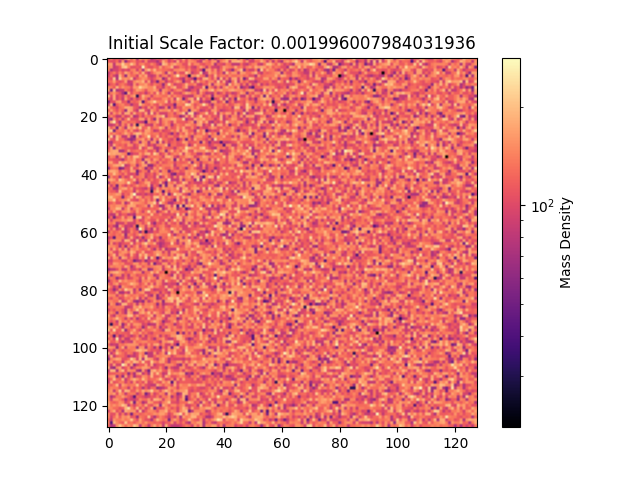

In [1]:
from IPython.display import Image
Image("initdensity.png")

This is the initial density field. To get it I used numpy to generate random coordinates for the 200,000 particles. It looks pretty uniform with some small variations, and it should look like that considering how I generated it. The scale factor is related to the starting redshift by $a = \frac{1}{1+z}$. My simulation starts at $z=500$, so the initial scale factor is $a_i = \frac{1}{501}$. It runs until $a_f = 1$.

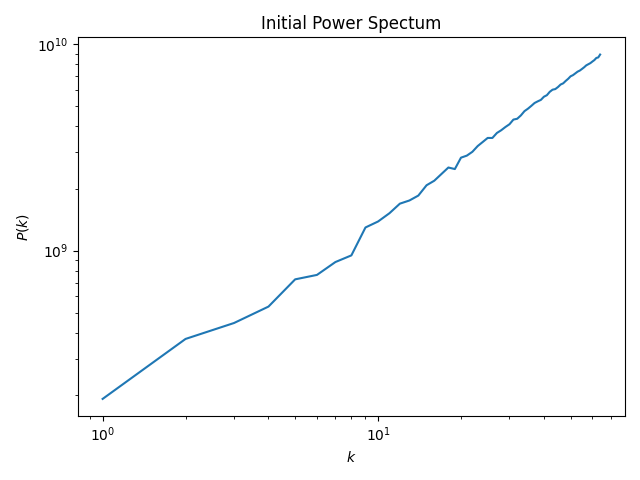

In [2]:
Image("initspectrum.png")

This is what the initial power spectrum looks like for our initial conditions. The math says a random field should result in $P(k) \propto k^n$, and that is what we see here as a straight line in log-space.

### Matter-Dominated

In [9]:
from IPython.display import Video
Video("mattercollapse.mp4")

This is the 3D evolution of the density map through time in the matter dominated universe. 

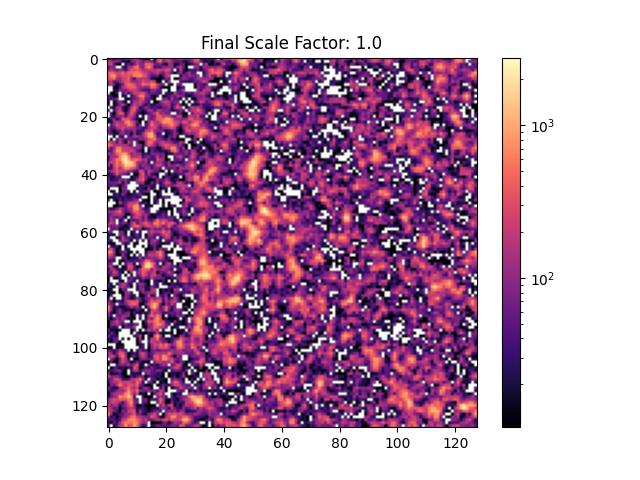

In [4]:
Image("Matter.png")

This plot is the density plot integrated through the z-axis to make it 2D. This is easier to visualize, but the integration removed some of the structure detail. There is a beautiful wall at ~(x=30, y=60 to 100), with some other less clear structures dotting the field.

A common way of measuring structure formation in cosmology with with the power spectrum. I calculated the power spectra of both the matter and radiation dominated universes using the final density output.

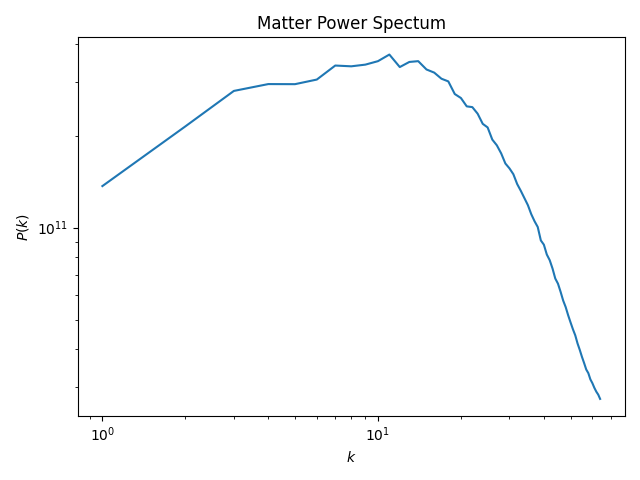

In [5]:
Image("matterspectrum.png")

This is the power spectrum for the matter-dominated universe. The actual value of the power does not mean much, but the shape contains valuable information about the progression of structure. To read this power spectrum, small k represents large structures, and large k and small structures. The matter-dominated universe has had enough structure growth to peak at scales of k=10. I will discuss the shape further after plotting the radiation power spectrum. For now, know that this power spectrum is actually rather similar to the overall shape of the actual observed power spectrum cosmologists see.

### Radiation-Dominated

In [11]:
Video("radiationcollapse.mp4")

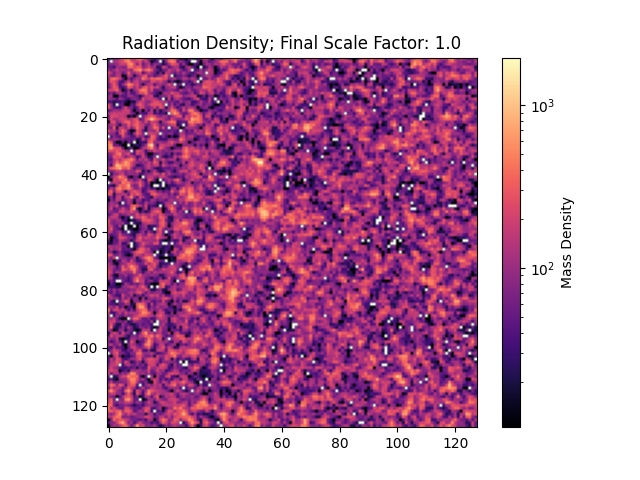

In [4]:
Image("Radiation.png")

Both the movie and the integrated density plots show that the radiation-dominated universe is lagging behind the matter-dominated universe in structure formation. The power spectrum will reveal by how much it is lagging behind.

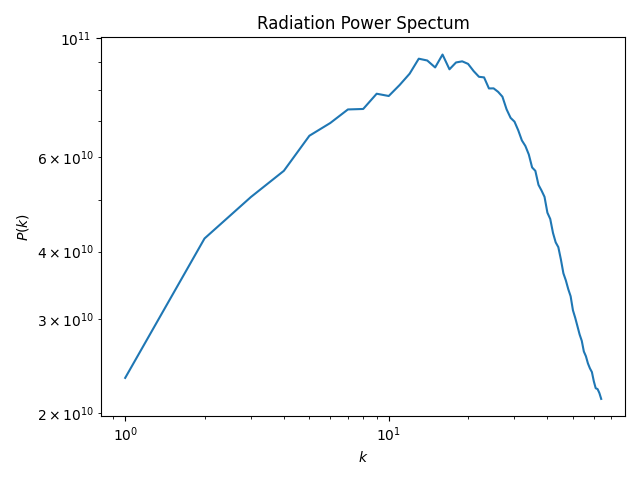

In [3]:
Image("radspectrum.png")

There are many interesting differences between this power spectrum and the matter one. The most important is that the peak is at a slightly larger k, which confirms our observation that structure formation has slowed. The difference in peak means qualitatevly that the radiation dominated universe has smaller structures than the matter dominated universe, and that large scale structure has not begun to form. The shapes of the power spectra are also different. The matter power spectrum has scales larger than the peak at a higher value, and the drop-off is nearly 2 orders of magnitude. The matter simulation is likely starting to reach the limit of how large structures can get inside the simulation box. The radiation universe has not even began to form large enough structures to think about limitations in the box size. 

# Conclusion

The project was a success in being able to qualitatively see the differences between a matter and a radiation dominated universe. It is apparent in all of the analysis that the matter universe is farther along in structure formation than the radiation universe. This simulation is difficult to debug since there's not much out there on what logarithmic vs linear growth actually looks like. The resolution of the simulation is only okay, and it does not compare to simulations ran by people doing real research on supercomputers. I find it cool that even a simulation this rough can still reproduce qualitative effects predicted by cosmology theory, and I only expected rough qualitative results going in. The power spectra being significantly different surprised me, I had thought that the resolution would not be good enough to produce good-looking spectra. Future work to improve this would be to make the units physical and to figure out how to get a dark-energy only universe to work.

### Targeted Rubric Sections

- Physical Problem
- Visualizations
- Github (https://github.com/astronerd7/Theoretical-Mechanics-Final-Project/tree/main)
- Animation
- Presentation
- Hamiltonian vs Lagrangian